# In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Metadata
- PassengerId = Passenger ID
- Survived = Weather Survived or not: 0 = No, 1 = Yes
- Pclass = Ticket class: 1 = 1st, 2 = 2nd, 3 = 3rd
- Name = Name of the Passenger
- Sex = Gender
- Age = Age in Years
- SibSp = No. of siblings / spouses aboard the Titanic
- Parch = No. of parents / children aboard the Titanic
- Ticket = Ticket number
- Fare = Passenger fare


In [26]:
# Libraries
import json
import pickle 
import ipywidgets as widgets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import(
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
# from teaching_tools.widgets import ConfusionMatrixWidget

In [7]:
def wrangle(filepath):
    # Drop unnecessary columns
    titanic_data = pd.read_csv(filepath)
    df = titanic_data.drop(columns=["PassengerId", "Name", "Sex", "Cabin", "Embarked", "Ticket"])
    return df

In [8]:
df = wrangle("train.csv")
print(df.shape)
df.head()

(891, 6)


,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [148]:
target = "Survived"
X = df.drop(columns="Survived")
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (891, 5)
y shape: (891,)


In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (712, 5)
y_train shape: (712,)
X_test shape: (179, 5)
y_test shape: (179,)


In [150]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (888, 5)


,Pclass,Age,SibSp,Parch,Fare
0,1,45.5,0,0,28.5000
1,2,23.0,0,0,13.0000
2,3,32.0,0,0,7.9250
3,3,26.0,1,0,7.8542
4,3,6.0,4,2,31.2750


In [151]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.6236


In [152]:
clf = make_pipeline(
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [153]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv=10, n_jobs=-1)
print(cv_acc_scores)

[0.66292135 0.70786517 0.73033708 0.69662921 0.83146067 0.79775281
 0.79775281 0.87640449 0.85227273 0.80681818]


In [154]:
params = {
    "simpleimputer__strategy":["mean", "median"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [155]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=10,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [156]:
model.fit(X_train_over, y_train_over)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [157]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.070388,0.002232,0.007468,0.000284,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.696629,0.662921,...,0.640449,0.797753,0.752809,0.775281,0.865169,0.784091,0.806818,0.748979,0.066917,21
1,0.077382,0.007214,0.007628,0.000165,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.674157,0.662921,...,0.674157,0.786517,0.775281,0.797753,0.853933,0.750000,0.795455,0.745557,0.063391,24
2,0.133700,0.002503,0.012389,0.000735,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.696629,0.674157,...,0.629213,0.808989,0.775281,0.741573,0.876404,0.795455,0.806818,0.752362,0.070393,20
3,0.148762,0.012366,0.013953,0.002369,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.696629,0.651685,...,0.674157,0.797753,0.775281,0.741573,0.865169,0.761364,0.795455,0.745569,0.062744,23
4,0.240193,0.022362,0.018363,0.002171,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.696629,0.662921,...,0.617978,0.808989,0.764045,0.741573,0.876404,0.784091,0.795455,0.746719,0.071877,22
5,0.211666,0.015063,0.017263,0.001522,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.696629,0.662921,...,0.662921,0.808989,0.775281,0.764045,0.865169,0.772727,0.806818,0.754584,0.062861,19
6,0.097501,0.008602,0.010222,0.002123,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.696629,0.685393,...,0.685393,0.820225,0.764045,0.808989,0.865169,0.863636,0.818182,0.770429,0.070218,18
7,0.086036,0.008778,0.009259,0.001814,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.696629,0.662921,...,0.674157,0.820225,0.797753,0.831461,0.865169,0.840909,0.818182,0.772651,0.072133,12
8,0.154083,0.012874,0.012908,0.001709,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.674157,0.696629,...,0.651685,0.842697,0.775281,0.820225,0.865169,0.852273,0.806818,0.771527,0.074252,17
9,0.163740,0.016246,0.014433,0.001522,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.685393,0.685393,...,0.674157,0.831461,0.786517,0.842697,0.865169,0.840909,0.806818,0.774885,0.070436,10


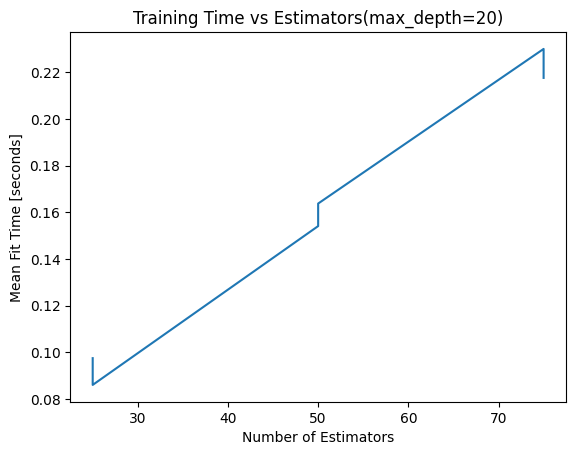

In [158]:
mask = cv_results["param_randomforestclassifier__max_depth"] == 20
plt.plot(cv_results[mask]["param_randomforestclassifier__n_estimators"], cv_results[mask]["mean_fit_time"])
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators(max_depth=20)");

In [159]:
model.best_estimator_
model

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [160]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)
print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9579
Test Accuracy: 0.7374


In [161]:
y_test.value_counts()

0    105
1     74
Name: Survived, dtype: int64

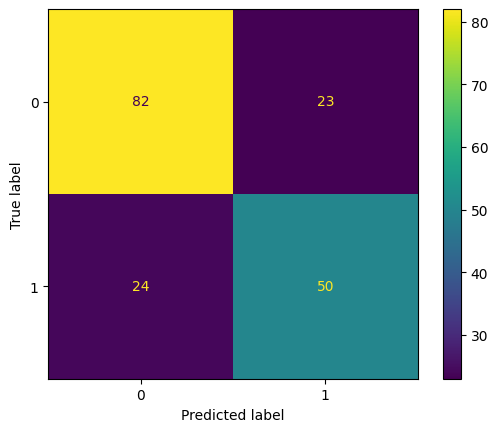

In [162]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

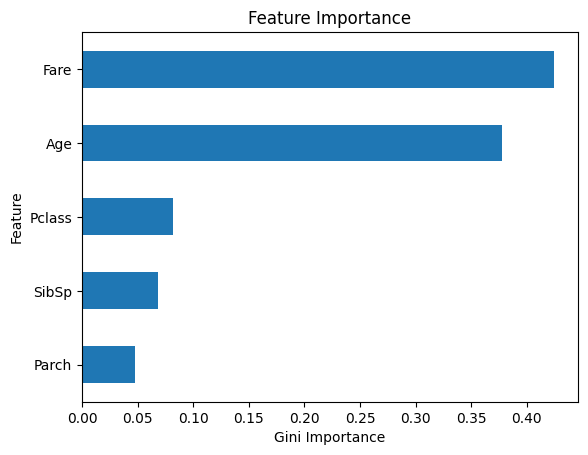

In [163]:
features= X_train_over.columns
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values()
feat_imp.tail(5).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

In [164]:
with open("titanic-model.pkl", "wb") as f:
    pickle.dump(model, f)

In [165]:
def make_predictions(data_filepath, model_filepath):
    X_test = wrangle(data_filepath)
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    y_test_pred = model.predict(X_test)
    y_test_pred = pd.Series(y_test_pred, index=X_test.index, name="Survived")
    
    return y_test_pred

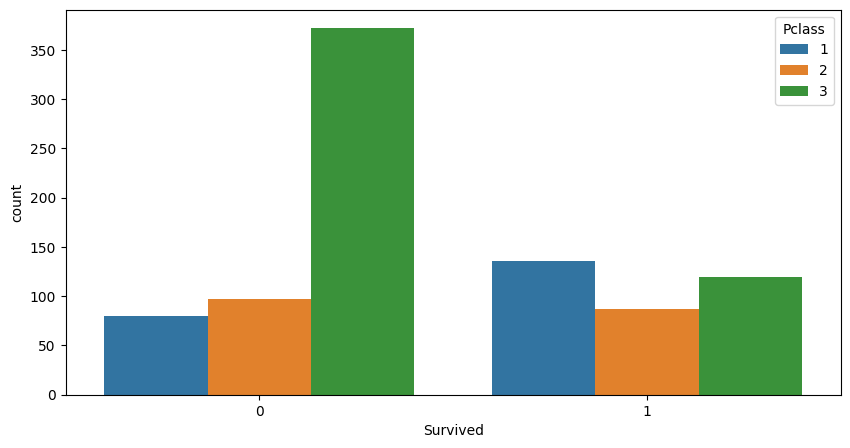

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(x='Survived', hue='Pclass', data=df)
plt.show()

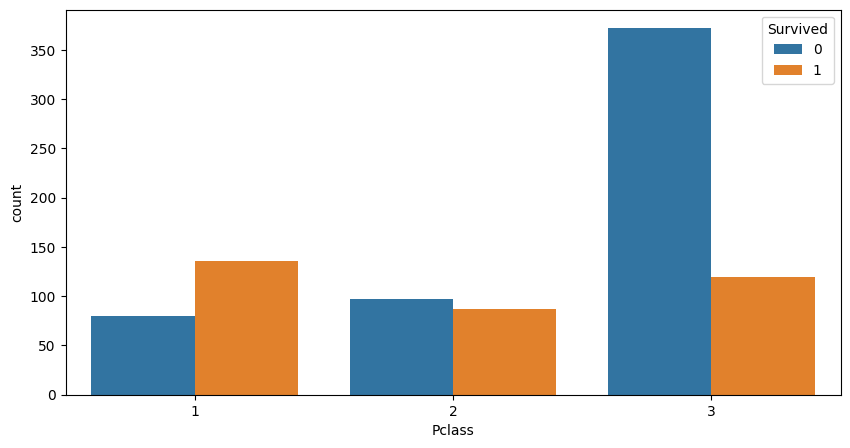

In [43]:
plt.figure(figsize=(10,5))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.show()